##### """
Implementing Jayasinghe et al. 2021 method for identifying variable star periodicities.
This is after the cuts implemented by Jayasinghe et al. 2021 to identify potential variabilities.

The procedure is as follows:

1. Run a GLS periodogram from 0.05 days to 1000 days. Keep the peaks that (a) have S/N of peaks > 5
(figure out how to quantify this), and (b) FAP < 10^-10 and (c) have power > 0.25
2. Run MHAOV, initializing N(harmonic) = 2. Keep peaks with S/N > 5 (figure out how to quantify this)
3. Run BLS, initializing 200 phase bins, and a min-max transit from 0.1-0.3 in phase. Keep
 powers<0.3.
4. Run PDM with the top 5 peaks from GLS, MHAOV, and BLS (15 peaks total). Select the best peak from
 this for fit
"""

In [ ]:
import sys
!{sys.executable} -m pip install P4J

In [ ]:
import sys
!{sys.executable} -m pip install astrobase

In [ ]:
!{sys.executable} -m pip install pwkit

In [1]:
from PyAstronomy.pyasl import foldAt
#import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
import pandas as pd
import scipy.optimize as opt
import P4J
import astrobase
import pwkit

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:

def period_fold(t, y, freq):

    phases = foldAt(t, period=1/freq)
    print(phases.max())
    sortIndi = np.argsort(phases)
    phases = phases[sortIndi]
    y = y[sortIndi]

    plt.plot(phases,y, 'bp')
    # plt.plot(t_fit, np.sin(t_fit*best_frequency))
    plt.title("Frequency: " + str(freq) + ", Period: " + str(1/freq))
    plt.show()
    
    return phases, y

def fit_peaks(p, t, f, df, lsg):
    phases = foldAt(t, p)
    print("PERIOD: ", p)

    sortIndi = np.argsort(phases)

    phases = phases[sortIndi]
    fg1 = f[sortIndi]
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)


    plt.errorbar(phases, fg1, yerr = df, fmt = "k.")

    t_fit = np.linspace(0, p, 100)
    y_fit = lsg.model(t_fit, 1/p)
    
    plt.plot(t_fit/p, y_fit)
    plt.xlabel("Phase"), plt.ylabel("Flux")
    plt.title("Phase Folded Best Fit at Period " + str(round(p, 3)))
    
    #pdf.savefig(fig)
    # plt.xlim(0, 0.7)
    plt.show()

    y_fit = lsg.model(t, 1/p)
    
def identify_peaks(frequency, power, n=20):
    """
    Finds the top n peaks in a periodogram given the frequency list, and 
    power list. Returns the top n frequencies and powers.
    """
    
    maxes = [np.where(power==sorted(power, reverse=True)[i]) for i in range(n)] # Find the indexes where power is sorted maximum to minimum.
    
    best_freqs = []
    powers = []
    faps = []
    
    for i in range(len(maxes)):
        # find the power and frequency at the max indices
        p_ = power[maxes[i][0][0]] 
        f_ = frequency[maxes[i][0][0]]
        best_freqs.append(f_)
        powers.append(p_)
        
    return best_freqs, powers


In [44]:
def get_band_ts(df, band):
    """
    returns the DataFrame Series for time, flux, and uncertainity given the formatted DataFrame. 
    The DataFrame must be formatted to have "band title" for every column, such as "g BJD" or "z dy"
    """
    return df[band + " MJD"], df[band + " MAG"], df[band + " MAGERR"]

bands = ["g", "r", "i", "z"]

candidates_df = pd.read_csv("Updated Candidate List.csv")
candidates = candidates_df["Candidate"]

candidate = candidates[1]
folder_ext = "data/"
candidate = "DC21saaw"
df = pd.read_csv(folder_ext + candidate + " 1.csv")

print(candidate, df)

band = "g"

# Exclude data below 5th and above 95th percentile to avoid outliers.

DC21saaw      Unnamed: 0         g MJD      g MAG  g MAGERR         r MJD      r MAG  \
0             0  59746.225558  20.094646  0.059377  59746.227010  19.479327   
1             1  59746.221824  19.818907  0.047121  59746.223276  19.286788   
2             2  59714.303520  19.381850  0.019786  59714.392011  18.439179   
3             3  59714.299802  19.257157  0.018697  59714.389748  18.521951   
4             4  59714.296074  19.161379  0.016835  59714.384043  18.671292   
..          ...           ...        ...       ...           ...        ...   
178         178           NaN        NaN       NaN           NaN        NaN   
179         179           NaN        NaN       NaN           NaN        NaN   
180         180           NaN        NaN       NaN           NaN        NaN   
181         181           NaN        NaN       NaN           NaN        NaN   
182         182           NaN        NaN       NaN           NaN        NaN   

     r MAGERR         i MJD      i MAG  i 

<ErrorbarContainer object of 3 artists>

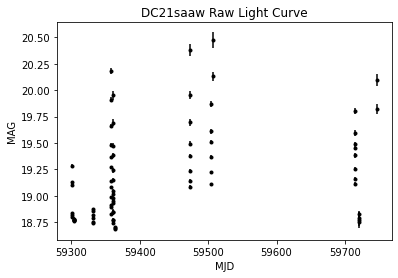

In [45]:
# Exclude data below 5th and above 95th percentile to avoid outliers.
# print(df)
cols = [band + ' MAG'] # one or more
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


t, f, dg = get_band_ts(df, band)

t = np.array(t.dropna())
f = np.array(f.dropna())
dg = np.array(dg.dropna())

# print(len(t))
plt.title(candidate + " Raw Light Curve")
plt.xlabel("MJD")
plt.ylabel("MAG")
plt.errorbar(t, f, dg, fmt="k.")

PERIOD:  0.20766088074477965


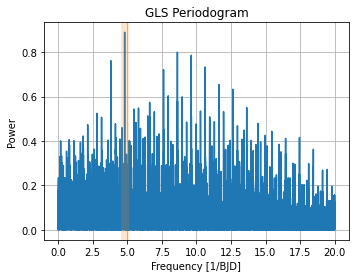

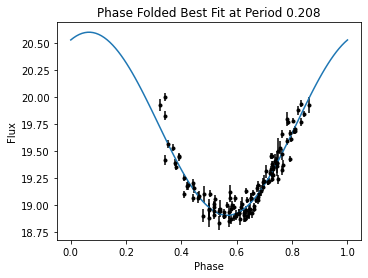

In [41]:
# Compute the GLS on Jayasinghe's frequency limits.
frequency_min = 1/1000
frequency_max = 1/0.05

ls = LombScargle(t, f, dg)
frequency, power = ls.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)
mean_power = np.mean(power)
# print(mean_power, len(frequency))
# Only keeping peaks with S/N > 5

sn_peaks = {"Frequency": [], "Power": [], "FAP": []}

for i in range(len(power)):
    freq = frequency[i]
    powe = power[i]
    if powe/mean_power >= 5:
        sn_peaks["Frequency"].append(freq)
        sn_peaks["Power"].append(powe)
        sn_peaks["FAP"].append(ls.false_alarm_probability(powe))
        
if len(sn_peaks["Frequency"]) == 0:
    print("Sorry, no significant peaks in this periodogram.\nDisplaying the full periodogram and best fit peak: ")
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(frequency, power)
    ymin, ymax = ax.get_ylim()
    ax.plot([frequency[np.argmax(power)], frequency[np.argmax(power)]], [ymin, ymax], linewidth=8, alpha=0.2)
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel('Frequency [1/BJD]')
    ax.set_ylabel('Power')
    plt.title('Full GLSPeriodogram')
    plt.show()
    ax = fig.add_subplot(1, 2, 2)
    fit_peaks(1/frequency[np.argmax(power)], t, f, dg, ls)
    
    ls_best_freqs, ls_best_power = [], []

else:
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(frequency, power)
    ymin, ymax = ax.get_ylim()
    ax.plot([sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])]], [ymin, ymax], linewidth=8, alpha=0.2)
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel('Frequency [1/BJD]')
    ax.set_ylabel('Power')
    plt.title('GLS Periodogram')
    plt.grid()

    fit_peaks(1/sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], t, f, dg, ls)

    # Finding top 5 frequencies
    #print(sn_peaks)
    ls_best_freqs, ls_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=len(sn_peaks["Frequency"]))

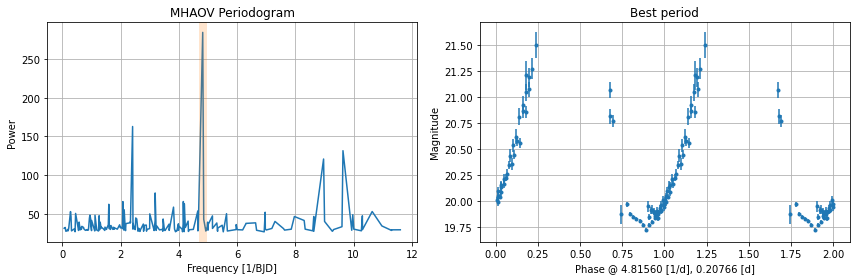

In [26]:
# Compute MHAOV based on Jayasinghe's initialization.

N_harm = 2
my_per = P4J.periodogram(method='MHAOV')
my_per.set_data(np.array(t), np.array(f), np.array(dg), Nharmonics = N_harm)
my_per.frequency_grid_evaluation(fmin=frequency_min, fmax=frequency_max, fresolution=1e-3)
my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
freq, per = my_per.get_periodogram()
fbest, pbest = my_per.get_best_frequencies() # Return best n_local_optima frequencies


# Find S/N > 5 signals

mean_power = np.mean(per)
sn_peaks = {"Frequency": [], "Power": []}

for i in range(len(per)):
    fre = freq[i]
    powe = per[i]
    if powe/mean_power >= 5:
        sn_peaks["Frequency"].append(fre)
        sn_peaks["Power"].append(powe)
        

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(sn_peaks["Frequency"], sn_peaks["Power"])
ymin, ymax = ax.get_ylim()
ax.plot([sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/BJD]')
ax.set_ylabel('Power')
plt.title('MHAOV Periodogram')
plt.grid()

# fig = plt.figure(figsize=(12, 4))
# ax = fig.add_subplot(1, 2, 1)
# ax.plot(freq, per)
# ymin, ymax = ax.get_ylim()
# ax.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2)
# ax.set_ylim([ymin, ymax])
# ax.set_xlabel('Frequency [1/MJD]')
# ax.set_ylabel('QMI Periodogram')
# plt.title('Periodogram')
# plt.grid()

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(t, 1.0/fbest[0])*fbest[0]
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]), 
            np.concatenate([f[idx], f[idx]]),
            np.concatenate([dg[idx], dg[idx]]), fmt='.')
plt.title('Best period')
ax.set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(fbest[0], 1.0/fbest[0]))
ax.set_ylabel('Magnitude')
plt.grid()
plt.tight_layout();


# Finding top 5 frequencies

mhaov_best_freqs, mhaov_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=5)

In [27]:
# BLS periodogram implementation
from astrobase import periodbase

phase_bins = 200
min_duration = 0.1
max_duration = 0.3

# bls_dict = abls.bls_serial_pfind(t, f, dg, 
#             nphasebins = phase_bins, mintransitduration=min_duration, 
#             maxtransitduration = max_duration, 
#             startp = frequency_min, endp = frequency_max) 


bls_dict = periodbase.bls_parallel_pfind(np.array(t), np.array(f), np.array(dg), nphasebins = phase_bins,
            mintransitduration=min_duration, 
            maxtransitduration = max_duration, 
            startp = frequency_min, endp = frequency_max, autofreq=False)


# bls_dict = periodbase.bls_serial_pfind(t, f, dg)

frequency = bls_dict["frequencies"]
power = bls_dict["lspvals"]

best_period = bls_dict["bestperiod"]
best_power = bls_dict["bestlspval"]

# print(bls_dict["nphasebins"])


[I 220729 00:33:39 __init__:84] An Astropy implementation of BLS is available because Astropy >= 3.1.
[I 220729 00:33:39 __init__:86] If you want to use it as the default periodbase BLS runner, call the periodbase.use_astropy_bls() function.
[I 220729 00:33:39 kbls:836] min P: 0.001, max P: 20.0, nfreq: 9999500, minfreq: 0.05, maxfreq: 1000.0
[I 220729 00:33:39 kbls:839] autofreq = False: using PROVIDED values for freq stepsize: 0.0001, nphasebins: 200, min transit duration: 0.1, max transit duration: 0.3
[I 220729 00:33:39 kbls:865] using 256 workers...
[I 220729 00:33:39 kbls:898] worker 1: minfreq = 0.050000, nfreqs = 39060
[I 220729 00:33:39 kbls:898] worker 2: minfreq = 3.956000, nfreqs = 39060
[I 220729 00:33:39 kbls:898] worker 3: minfreq = 7.862000, nfreqs = 39060
[I 220729 00:33:39 kbls:898] worker 4: minfreq = 11.768000, nfreqs = 39060
[I 220729 00:33:39 kbls:898] worker 5: minfreq = 15.674000, nfreqs = 39060
[I 220729 00:33:39 kbls:898] worker 6: minfreq = 19.580000, nfreqs 

9999500 50785
PERIOD:  1.5030813166992332


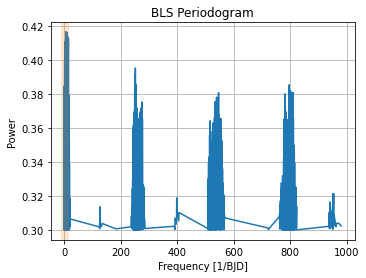

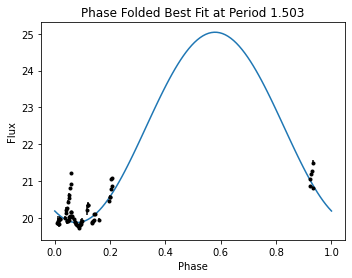

In [29]:
# Continuation of BLS periodogram, plotting perioodgram and model

sn_peaks = {"Frequency": [], "Power": []}

for i in range(len(power)):
    freq = frequency[i]
    powe = power[i]
    if powe >= 0.3: # Fix this relation... don't know what's up. Power is in the 1000s.
        sn_peaks["Frequency"].append(freq)
        sn_peaks["Power"].append(powe)

print(len(frequency), len(sn_peaks["Frequency"]))

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(sn_peaks["Frequency"], sn_peaks["Power"])
ymin, ymax = ax.get_ylim()
ax.plot([sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/BJD]')
ax.set_ylabel('Power')
plt.title('BLS Periodogram')
plt.grid()

fit_peaks(1/sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], t, f, dg, ls)

# Finding top 5 frequencies

bls_best_freqs, bls_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=5)

In [30]:
# Compute PDM based on Jayasinghe's paper. Note that candidate DC21badcl would be flagged because its GLS period did not match the MHAOV or BLS period.
from pwkit import pdm
nbins = 20

periods = [*list(1/np.array(ls_best_freqs)), *list(1/np.array(mhaov_best_freqs)), *list(1/np.array(bls_best_freqs))]

pdm_dict = pwkit.pdm.pdm(t, f, dg, periods, nbin=nbins)

theta = pdm_dict[0]

PERIOD:  0.20765667871192225
THETA:  0.11247709091055505
PERIOD:  0.20765843987464905
THETA:  0.13090358039599467
PERIOD:  0.11153992265462875
THETA:  0.1501265802226485
PERIOD:  0.10383030027151108
THETA:  0.16119541428637035
PERIOD:  0.4153168797492981
THETA:  0.2623671995273983


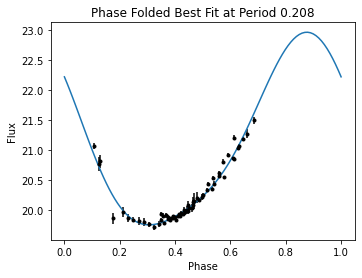

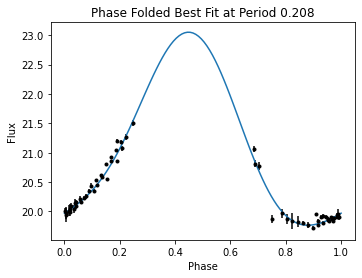

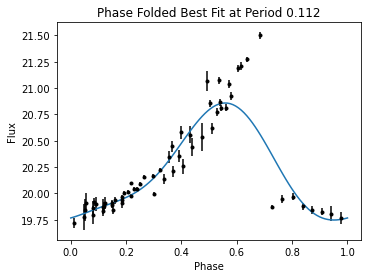

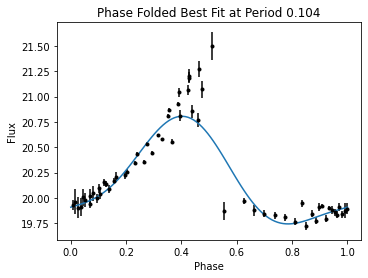

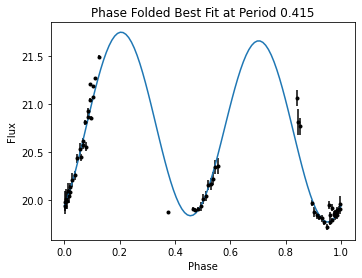

In [31]:
# We want the minimum theta statistic to find the best periods.
# I will sort the periods by increasing theta statistic, 
# then plot the top 5 phase folded graphs according to the statistic.
n = 5
ls = LombScargle(t, f, dg, nterms = 2)
indices = np.argsort(theta)
theta_sorted = theta[indices]
periods_sorted = np.array(periods)[indices]
plt.close()
for i in range(n):
    fit_peaks(periods_sorted[i], t, f, dg, ls)
    print("THETA: ", theta_sorted[i])

In [ ]:
# Run fits for each band from top period for all bands

pers = [0.2, 0.2471027374267578, 0.21194972097873688,  0.21194639765816328, 
        0.19793155329450854, 0.12585264444351196, 0.20263835787773132, 3.124023914337158]

pers = [0.6453082759220174, 0.21954700125452684, 0.6215040683746338, 0.28691935539245605, 0.3698224723339081, 2.474022626876831]
df = pd.read_csv("data/" + candidate + " 1.csv")
print(df)
bands = ["g", "r", "i", "z"]
for band in bands:
    cols = [band + ' MAG'] # one or more
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1

    df2 = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


    #t, f, dg = get_band_ts(df2, band)
    t, f, dg = df2[band + " MJD"], df2[band + " MAG"], df2[band + " MAGERR"]

    t = np.array(t.dropna())
    f = np.array(f.dropna())
    dg = np.array(dg.dropna())
    ls = LombScargle(t, f, dg, nterms = 1)
    frequency, power = ls.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)
    print(ls.false_alarm_probability(power[np.argmax(power)]))
    for p in pers:
        fit_peaks(p, t, f, dg, ls)

In [ ]:
from functools import wraps
import logging

def suspendlogging(func):
    @wraps(func)
    def inner(*args, **kwargs):
        log = logging.getLogger()
        previousloglevel = log.getEffectiveLevel()
        try:
            return func(*args, **kwargs)
        finally:
            log.setLevel(previousloglevel)
    return inner

In [ ]:
"""
Looking good. Now making this reproducable so it can be done autonomously:
"""

phase_bins = 200
min_duration = 0.1
max_duration = 0.3
frequency_min = 1/1000
frequency_max = 1/0.05
N_harm = 2
num = 5
    
from astrobase import periodbase
from pwkit import pdm

# Function to find best GLS peaks:
def gls_peaks(t, y, dy):
    # Compute the GLS on Jayasinghe's frequency limits.
    ls = LombScargle(t, y, dy)
    frequency, power = ls.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)
    mean_power = np.mean(power)
    # print(mean_power, len(frequency))
    # Only keeping peaks with S/N > 5

    sn_peaks = {"Frequency": [], "Power": [], "FAP": []}

    for i in range(len(power)):
        freq = frequency[i]
        powe = power[i]
        if powe/mean_power >= 5:
            # ADDING ANOTHER CONDITIONAL TO MAKE SURE THAT FAP < 10^-10
            if ls.false_alarm_probability(powe) < 10**(-10):
                # print(freq, ls.false_alarm_probability(powe))
                sn_peaks["Frequency"].append(freq)
                sn_peaks["Power"].append(powe)
                sn_peaks["FAP"].append(ls.false_alarm_probability(powe))

    if len(sn_peaks["Frequency"]) < 5:
        n = len(sn_peaks["Frequency"])
    else:
        n = 5
   
    if n == 0:
        print("Sorry, no significant peaks in this periodogram")
        ls_best_freqs, ls_best_power = [], []
        flag = True

    else:
        # fit_peaks(1/sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], t, f, dg, ls)

        # Finding top 5 frequencies
        # ls_best_freqs, ls_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=n)
        flag = False
        
    return sn_peaks, flag

def mhaov_peaks(t, y, dy):
     # Compute MHAOV based on Jayasinghe's initialization.
    print("COMPUTING MHAOV")

    my_per = P4J.periodogram(method='MHAOV')
    my_per.set_data(np.array(t), np.array(y), np.array(dy), Nharmonics = N_harm)
    my_per.frequency_grid_evaluation(fmin=frequency_min, fmax=frequency_max, fresolution=1e-3)
    my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
    freq, per = my_per.get_periodogram()
    fbest, pbest = my_per.get_best_frequencies() # Return best n_local_optima frequencies


    # Find S/N > 5 signals

    mean_power = np.mean(per)
    sn_peaks = {"Frequency": [], "Power": []}

    for i in range(len(per)):
        fre = freq[i]
        powe = per[i]
        if powe/mean_power >= 5:
            sn_peaks["Frequency"].append(fre)
            sn_peaks["Power"].append(powe)

    # Finding top 5 frequencies
    
    if len(sn_peaks["Frequency"]) < 5:
        n = len(sn_peaks["Frequency"])
    else:
        n = 5
        
    if len(sn_peaks["Frequency"]) < 5:
        num = len(sn_peaks["Frequency"])
        
    if len(sn_peaks["Frequency"]) == 0:
        print("Sorry, no significant peaks in this periodogram")
        mhaov_best_freqs, mhaov_best_power = [], []
        flag = True

    else:
        # fit_peaks(1/sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], t, f, dg, ls)
        mhaov_best_freqs, mhaov_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=n)
        flag = False
        
    return mhaov_best_freqs, mhaov_best_power, flag

@suspendlogging
def bls_peaks(t, y, dy):
    # BLS periodogram implementation
    logger = logging.getLogger()
    logger.setLevel(level=logging.WARNING)
    print("COMPUTING BLS")

    bls_dict = periodbase.bls_parallel_pfind(np.array(t), np.array(y), np.array(dy), nphasebins = phase_bins,
                mintransitduration=min_duration, 
                maxtransitduration = max_duration, 
                startp = frequency_min, endp = frequency_max, autofreq=False)

    frequency = bls_dict["frequencies"]
    power = bls_dict["lspvals"]
    

    sn_peaks = {"Frequency": [], "Power": []}

    for i in range(len(power)):
        freq = frequency[i]
        powe = power[i]
        if powe >= 0.3: # Fix this relation... don't know what's up. Power is in the 1000s.
            sn_peaks["Frequency"].append(freq)
            sn_peaks["Power"].append(powe)

    # Finding top 5 frequencies
    
    if len(sn_peaks["Frequency"]) < 5:
        n = len(sn_peaks["Frequency"])
    else:
        n = 5
        
    if len(sn_peaks["Frequency"]) < 5:
        num = len(sn_peaks["Frequency"])
        
    if len(sn_peaks["Frequency"]) == 0:
        print("Sorry, no significant peaks in this periodogram")
        bls_best_freqs, bls_best_power = [], []
        flag = True
        
    else:
        # fit_peaks(1/sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], t, f, dg)
        bls_best_freqs, bls_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=n)
        flag = False
        
    return bls_best_freqs, bls_best_power, flag
   
def best_pdm(t, y, dy, periods):   
    # Compute PDM based on Jayasinghe's paper. Note that candidate DC21badcl would be flagged because its GLS period did not match the MHAOV or BLS period.
    print("COMPUTING PDM")
    nbins = 20

    pdm_dict = pwkit.pdm.pdm(t, y, dy, periods, nbin=nbins)

    theta = pdm_dict[0]
    indices = np.argsort(theta)
    
    return np.array(periods)[indices]
    
def find_variability(t, y, dy):
    ls_best_freqs, ls_best_power = gls_peaks(t, y, dy)
    mhaov_best_freqs, mhaov_best_power = mhaov_peaks(t, y, dy)
    bls_best_freqs, bls_best_power = bls_peaks(t, y, dy)
    
    periods = [*list(1/np.array(ls_best_freqs)), *list(1/np.array(mhaov_best_freqs)), *list(1/np.array(bls_best_freqs))]
    
    best_periods = best_pdm(t, y, dy, periods)
    
    return best_periods
    
    
def find_common(periods_dictionary, count_level = 2):   
    # First find only unique values for each band. 
    # Then, concatenate the bands and find unique values and their counts for the concatenated list.
    
    dec = 2
    g = np.unique(np.around(np.array(periods_dictionary["g"]), decimals = dec))
    r = np.unique(np.around(np.array(periods_dictionary["r"]), decimals = dec))
    i = np.unique(np.around(np.array(periods_dictionary["i"]), decimals = dec))
    z = np.unique(np.around(np.array(periods_dictionary["z"]), decimals = dec))

    
    # print(g, r, i, z)
    
    conc = np.array(list(g) + list(r) + list(i) + list(z))
    if len(conc) == 0:
        return [], []
    
    else:
        conc_full = np.array(list(periods_dictionary["g"]) + list(periods_dictionary["r"]) + list(periods_dictionary["i"]) + list(periods_dictionary["z"]))

        conc_unique, conc_counts = np.unique(conc, return_counts = True)
        # print(conc, conc_counts, conc_unique)
        counts, unique = (np.array(t) for t in zip(*sorted(zip(conc_counts, conc_unique), reverse = True)))
        counts_ = counts[counts >= count_level]
        unique_ = unique[counts >= count_level]

        total_uniques = []
        total_counts = []
        for i in range(len(unique_)):
            u = unique_[i]
            for c in conc_full:
                if str(u) in str(c):
                    # print(u, c)
                    total_uniques.append(c)
                    total_counts.append(counts_[i])
                    break

        return total_uniques, total_counts

In [ ]:
import warnings

def get_periods(df):
    warnings.filterwarnings("ignore")
    gls_dictionary = {"g": [], "r": [], "i":[], "z":[]}
    periods_list = []

    # Set the dataframe
    cols = []
    for band in bands:
        cols.append(band + " MAG")

    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    dfband = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    gls_flag_count = 0

    for band in bands:
        print("ANALYZING GLS DATA FOR BAND " + band)

        t, f, dg = get_band_ts(dfband, band)
        t = np.array(t.dropna())
        f = np.array(f.dropna())
        dg = np.array(dg.dropna())
        peaks, flag = gls_peaks(t=t, y=f, dy=dg)
        if flag == True:
            gls_flag_count = gls_flag_count + 1
            
        gls_dictionary[band] = 1/np.array(peaks["Frequency"])
        print("FINISHED ANALYZING GLS DATA FOR BAND " + band)
    
    if gls_flag_count >= 2:
        print("skipping candidate")
        return []
        
    else:

        if len(gls_dictionary)==0:
            gls_periods = []
            gls_counts = []

        else:
            gls_periods, gls_counts = find_common(gls_dictionary)

        if len(gls_periods) != 0:
            periods_list += gls_periods

        periods_dictionary = {"g": [], "r": [], "i":[], "z":[]}
        for band in bands:
            print("ANALYZING REST OF DATA FOR BAND " + band)

            t, f, dg = get_band_ts(dfband, band)
            t = np.array(t.dropna())
            f = np.array(f.dropna())
            dg = np.array(dg.dropna())

            mhaov_best_freqs, mhaov_best_power, mhaov_flag = mhaov_peaks(t, f, dg)
            bls_best_freqs, bls_best_power, bls_flag = bls_peaks(t, f, dg)

            periods = [*list(1/np.array(mhaov_best_freqs)), *list(1/np.array(bls_best_freqs))]

            periods_dictionary[band] = best_pdm(t, f, dg, periods)

            print("FINISHED ANALYZING REST OF DATA FOR BAND " + band)


        if len(periods_dictionary)==0:
            rest_periods = []
            rest_counts = []

        else:
            rest_periods, rest_counts = find_common(periods_dictionary)

        if len(rest_periods) != 0:
            periods_list += rest_periods

        warnings.resetwarnings()
        return periods_list
    # print(df)

In [ ]:
# Implement the minimizing mean FAP procedure for all of these periods.
# periods_list = [0.3505678573747537]

def fap_minimization(df, periods):
    faps = []
    for p in periods:
        print("STARTING FAP CALCULATION FOR PERIOD: " + str(p))
        fap = []
        for band in bands[1:]:
            # band = "r"
            tg, fg, dg = get_band_ts(df, band)
            tg = tg.dropna()
            fg = fg.dropna()
            dg = dg.dropna()

            # lsg = LombScargle(tg, fg, dg)
            # frequency, power = lsg.autopower(minimum_frequency=0.001, maximum_frequency=50, samples_per_peak=15)
            #freqg, pg = lsg.autopower(minimum_frequency=0.05, maximum_frequency=0.2, samples_per_peak=15)
            lsg = LombScargle(tg, fg, dg)
            frequency, power = lsg.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)
            power = abs(power)


                # fit_peaks(p, tg, fg, lsg)
            fap.append(lsg.false_alarm_probability(lsg.power(1/p)))

        faps.append(np.mean(fap))
        # print(fap)

    return periods[faps.index(min(faps))]


In [ ]:
# Okay. NOW make this whole thing autonomous (famous last words)
import matplotlib.backends.backend_pdf
print(len(candidates))
import time
start = time.time()
for candidate in candidates:
    pdf = matplotlib.backends.backend_pdf.PdfPages("pdf/" + candidate + ".pdf", metadata =  {'Creator': 'DECAT-fitting', 'Author': 'Garima Prabhakar', 'Title': 'Awesome Candidate: ' + candidate})
    print(candidate)
    df = pd.read_csv("data/" + candidate + " 1.csv")
    
    # print(df)
    periods_list = get_periods(df)
    # print(periods_list)
    if periods_list != []:
        best_fit_period = fap_minimization(df, periods_list)
        # best_fit_period = 0.22

        # Compute the GLS on Jayasinghe's frequency limits.
        frequency_min = 1/1000
        frequency_max = 1/0.05

        for band in bands:

            t, f, dg = get_band_ts(df, band)
            t = np.array(t.dropna())
            f = np.array(f.dropna())
            dg = np.array(dg.dropna())

            print("FITTING BEST PEFRIOD TO BAND " + band)
            ls = LombScargle(t, f, dg)
            frequency, power = ls.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)

            fig = plt.figure(figsize=(12, 4))
            ax = fig.add_subplot(1, 2, 1)
            ax.plot(frequency, power)
            ymin, ymax = ax.get_ylim()
            ax.plot([frequency[np.argmax(power)], frequency[np.argmax(power)]], [ymin, ymax], linewidth=8, alpha=0.2)
            ax.set_ylim([ymin, ymax])
            ax.set_xlabel('Frequency [1/BJD]')
            ax.set_ylabel('Power')
            plt.title('GLSPeriodogram Band ' + band)
            plt.grid()
            
            # for fig in xrange(1, figure().number): ## will open an empty extra figure :(
            pdf.savefig(fig)
            

            fit_peaks(best_fit_period, t, f, dg, ls, pdf)

pdf.close()
end = time.time()
print("TIME: ", end-start)

In [ ]:
band = "g"
import matplotlib.pyplot as plt
%matplotlib inline

file = "global/homes/g/garimap/AwesomeDECAMLightCurveFitting/DECAT-fitting/c4d_210322_091333_ori-Copy1.04.fits.fz.lightcurve.csv"
# t, f, dg = get_band_ts(df, band)
df = pd.read_csv(file)
t = df["MJD"]
f = df["STD Flux"]
dg = df["STD dFlux"]

t = np.array(t.dropna())
f = np.array(f.dropna())
dg = np.array(dg.dropna())

print("FITTING BEST PEFRIOD TO BAND " + band)
ls = LombScargle(t, f, dg)
frequency, power = ls.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(frequency, power)
ymin, ymax = ax.get_ylim()
ax.plot([frequency[np.argmax(power)], frequency[np.argmax(power)]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/BJD]')
ax.set_ylabel('Power')
plt.title('GLSPeriodogram Band ' + band)
plt.grid()
plt.show()

fit_peaks(best_fit_period, t, f, dg, ls)